In [1]:
#| label: cell-1-finding_effective_model

import numpy as np
from sympy import symbols, Matrix, sqrt, Eq, exp, I, pi, Add, MatAdd
from sympy.physics.vector import ReferenceFrame

t_1, t_2, m = symbols("t_1 t_2 m", real=True)
alpha = symbols(r"\alpha")

H = Matrix([
    [m, t_1 * alpha, 0, 0],
    [t_1 * alpha.conjugate(), m, t_2, 0],
    [0, t_2, -m, t_1 * alpha],
    [0, 0, t_1 * alpha.conjugate(), -m]]
)
Eq(symbols("H"), H, evaluate=False)

Eq(H, Matrix([
[                    m, \alpha*t_1,                     0,          0],
[t_1*conjugate(\alpha),          m,                   t_2,          0],
[                    0,        t_2,                    -m, \alpha*t_1],
[                    0,          0, t_1*conjugate(\alpha),         -m]]))

In [2]:
#| label: cell-2-finding_effective_model

k_x, k_y = symbols("k_x k_y", real=True)
N = ReferenceFrame("N")
a_1 = (sqrt(3) * N.y + N.x) / 2
a_2 = (sqrt(3) * N.y - N.x) / 2
k = (4 * pi / 3 + k_x) * N.x + k_y * N.y

alpha_k = (1 + exp(I * k.dot(a_1)) + exp(I * k.dot(a_2))).expand(complex=True, trig=True)
Eq(alpha, alpha_k, evaluate=False)

Eq(\alpha, -sqrt(3)*I*sin(k_x/2)*sin(sqrt(3)*k_y/2) - sqrt(3)*sin(k_x/2)*cos(sqrt(3)*k_y/2) - I*sin(sqrt(3)*k_y/2)*cos(k_x/2) - cos(k_x/2)*cos(sqrt(3)*k_y/2) + 1)

In [3]:
#| label: cell-3-finding_effective_model

vecs = H.subs({alpha: 0, m: 0}).diagonalize(normalize=True)[0]
vecs

Matrix([
[1, 0,          0,         0],
[0, 0, -sqrt(2)/2, sqrt(2)/2],
[0, 0,  sqrt(2)/2, sqrt(2)/2],
[0, 1,          0,         0]])

In [4]:
#| label: cell-4-finding_effective_model

from pymablock import block_diagonalize

H_tilde, U, U_adjoint = block_diagonalize(
    H.subs({alpha: alpha_k}),
    symbols=(k_x, k_y, m),
    subspace_eigenvectors=[vecs[:, :2], vecs[:, 2:]]
)

In [5]:
#| label: cell-5-finding_effective_model

H_tilde.dimension_names

(k_x, k_y, m)

In [6]:
#| label: cell-6-finding_effective_model

k_square = np.array([[0, 1, 2], [2, 1, 0]])
k_cube = np.array([[0, 1, 2, 3], [3, 2, 1, 0]])

In [7]:
#| label: cell-7-finding_effective_model

k_powers = np.mgrid[:4, :4]
k_square = k_powers[..., np.sum(k_powers, axis=0) == 2]
k_cube = k_powers[..., np.sum(k_powers, axis=0) == 3]

In [8]:
#| label: cell-8-finding_effective_model

def H_tilde_AA(*orders):
    return Add(*H_tilde[0, 0, orders[0], orders[1], orders[2]].compressed()).simplify()

In [9]:
#| label: cell-9-finding_effective_model

mass_term = H_tilde_AA([0], [0], [1])
kinetic = H_tilde_AA(*k_square, 0)
mass_correction = H_tilde_AA(*k_square, 1)
cubic = H_tilde_AA(*k_cube, 0)
MatAdd(mass_term + kinetic, mass_correction + cubic, evaluate=False)

Matrix([
[                                                m, 3*t_1**2*(-k_x**2 - 2*I*k_x*k_y + k_y**2)/(4*t_2)],
[3*t_1**2*(-k_x**2 + 2*I*k_x*k_y + k_y**2)/(4*t_2),                                                -m]]) + Matrix([
[                                    3*m*t_1**2*(-k_x**2 - k_y**2)/(2*t_2**2), sqrt(3)*t_1**2*(k_x**3 - 5*I*k_x**2*k_y + 9*k_x*k_y**2 + 3*I*k_y**3)/(8*t_2)],
[sqrt(3)*t_1**2*(k_x**3 + 5*I*k_x**2*k_y + 9*k_x*k_y**2 - 3*I*k_y**3)/(8*t_2),                                      3*m*t_1**2*(k_x**2 + k_y**2)/(2*t_2**2)]])

In [10]:
#| label: cell-10-finding_effective_model

import tinyarray as ta
import matplotlib.backends
import scipy.linalg
from scipy.sparse.linalg import eigsh
import numpy as np
import kwant
import matplotlib.pyplot as plt
color_cycle = ["#5790fc", "#f89c20", "#e42536"]

from pymablock import block_diagonalize


sigma_z = ta.array([[1, 0], [0, -1]], float)
sigma_x = ta.array([[0, 1], [1, 0]], float)

syst = kwant.Builder()
lat = kwant.lattice.square(norbs=2)
L, W = 200, 40

def normal_onsite(site, mu_n, t):
    return (-mu_n + 4 * t) * sigma_z

def sc_onsite(site, mu_sc, Delta, t):
    return (-mu_sc + 4 * t) * sigma_z + Delta * sigma_x

syst[lat.shape((lambda pos: abs(pos[1]) < W and abs(pos[0]) < L), (0, 0))] = normal_onsite
syst[lat.shape((lambda pos: abs(pos[1]) < W and abs(pos[0]) < L / 3), (0, 0))] = sc_onsite
syst[lat.neighbors()] = lambda site1, site2, t: -t * sigma_z

def barrier(site1, site2):
    return (abs(site1.pos[0]) - L / 3) * (abs(site2.pos[0]) - L / 3) < 0

syst[(hop for hop in syst.hoppings() if barrier(*hop))] = (
    lambda site1, site2, t_barrier: -t_barrier * sigma_z
)

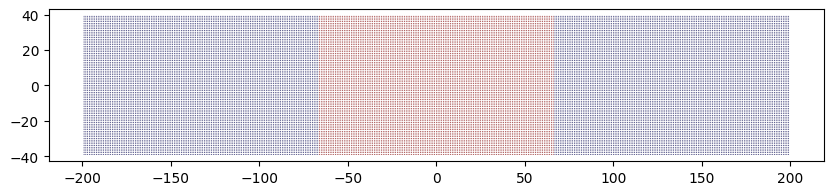

'The system has 31521 sites.'

In [11]:
#| label: cell-11-finding_effective_model

kwant.plot(
    syst,
    fig_size=(10, 6),
    site_color=(lambda site: abs(site.pos[0]) < L / 3),
    colorbar=False,
    cmap="seismic",
    hop_lw=0,
)

syst = syst.finalized()
f"The system has {len(syst.sites)} sites."

In [12]:
#| label: cell-12-finding_effective_model

params = dict(
    mu_n=0.05,
    mu_sc=0.3,
    Delta=0.05,
    t=1.,
    t_barrier=0.,
)

h_0 = syst.hamiltonian_submatrix(params=params, sparse=True).real

In [13]:
#| label: cell-13-finding_effective_model

barrier = syst.hamiltonian_submatrix(
    params={**{p: 0 for p in params.keys()}, "t_barrier": 1}, sparse=True
).real
delta_mu = (
    kwant.operator.Density(syst, (lambda site: sigma_z * site.pos[0] / L)).tocoo().real
)

In [14]:
#| label: cell-14-finding_effective_model

# %%time

vals, vecs = eigsh(h_0, k=4, sigma=0)
vecs, _ = scipy.linalg.qr(vecs, mode="economic")  # orthogonalize the vectors

In [15]:
#| label: cell-15-finding_effective_model

# %%time

H_tilde, *_ = block_diagonalize([h_0, barrier, delta_mu], subspace_eigenvectors=[vecs])

In [16]:
#| label: cell-16-finding_effective_model

# %%time

# Combine all the perturbative terms into a single 4D array
fill_value = np.zeros((), dtype=object)
fill_value[()] = np.zeros_like(H_tilde[0, 0, 0, 0])
h_tilde = np.array(np.ma.filled(H_tilde[0, 0, :3, :3], fill_value).tolist())

In [17]:
#| label: cell-17-finding_effective_model

def effective_energies(h_tilde, barrier, delta_mu):
    barrier_powers = barrier ** np.arange(3).reshape(-1, 1, 1, 1)
    delta_mu_powers = delta_mu ** np.arange(3).reshape(1, -1, 1, 1)
    return scipy.linalg.eigvalsh(
        np.sum(h_tilde * barrier_powers * delta_mu_powers, axis=(0, 1))
    )

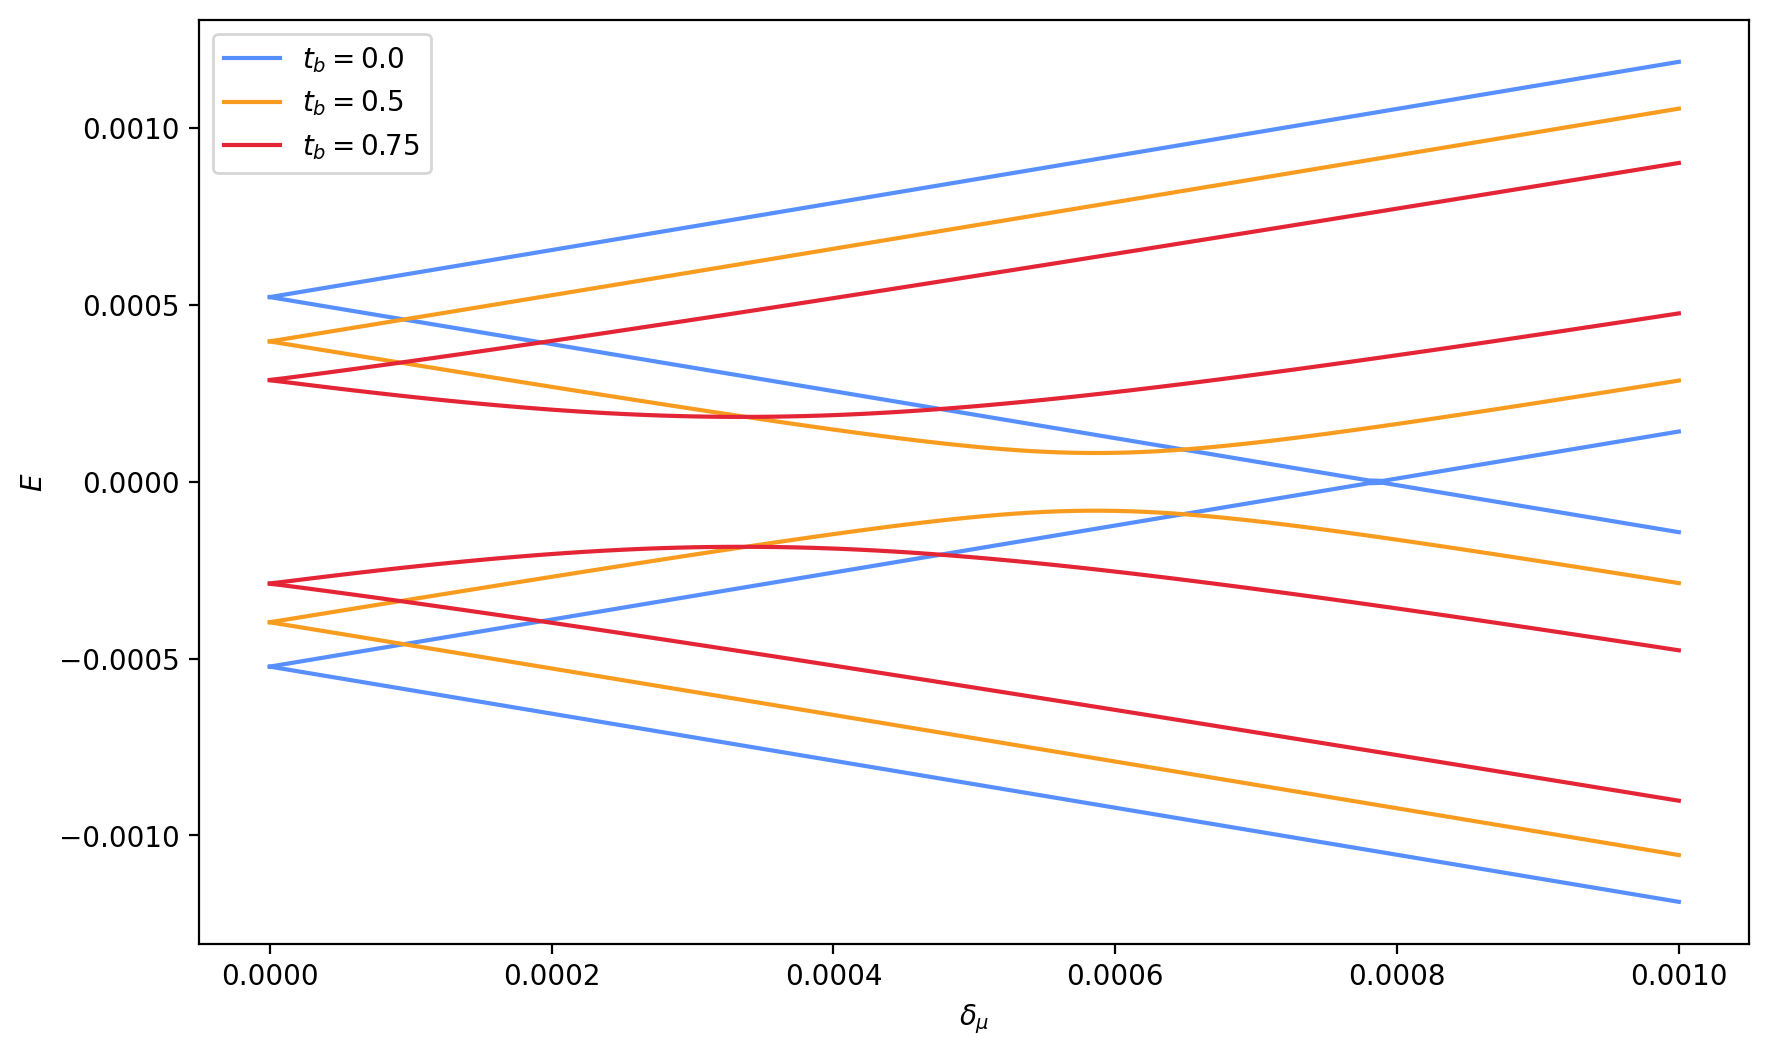

In [18]:
#| label: cell-18-finding_effective_model

# :tags: [hide-input]

# %%time

barrier_vals = np.array([0, 0.5, .75])
delta_mu_vals = np.linspace(0, 10e-4, num=101)
results = [
    np.array([effective_energies(h_tilde, bar, dmu) for dmu in delta_mu_vals])
    for bar in barrier_vals
]

plt.figure(figsize=(10, 6), dpi=200)
[
    plt.plot(delta_mu_vals, result, color=color, label=[f"$t_b={barrier}$"] + 3 * [None])
    for result, color, barrier in zip(results, color_cycle, barrier_vals)
]
plt.xlabel(r"$\delta_\mu$")
plt.ylabel(r"$E$")
plt.legend();